In [1]:
import os
import csv # noqa
import json
import struct
import io
import numpy as np
import requests
import base64
import random
from PIL import Image
from IPython.display import Markdown, display, HTML, IFrame
from pprint import pprint
from random import sample
from urllib.request import urlretrieve
from k12libs.utils.nb_easy import k12ai_get_top_dir, RACEURL
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT

In [2]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

## 标签描述

In [3]:
# chr(70), ord('a')
table = '''
标签(label) | 描述(description)
:---: | :---:
<img width=300/> | <img width=300/> 
'''

label_names = []

for i in range(26):
    char = chr(97 + i)
    CHAR = char.upper()
    table += f'{i} | {char}/{CHAR} \n'
    label_names.append(char)
    
Markdown(table)


标签(label) | 描述(description)
:---: | :---:
<img width=300/> | <img width=300/> 
0 | a/A 
1 | b/B 
2 | c/C 
3 | d/D 
4 | e/E 
5 | f/F 
6 | g/G 
7 | h/H 
8 | i/I 
9 | j/J 
10 | k/K 
11 | l/L 
12 | m/M 
13 | n/N 
14 | o/O 
15 | p/P 
16 | q/Q 
17 | r/R 
18 | s/S 
19 | t/T 
20 | u/U 
21 | v/V 
22 | w/W 
23 | x/X 
24 | y/Y 
25 | z/Z 


## 开发调试

[模型权重训练](http://116.85.5.40:8118/notebooks/cv/pl/pl_emnist_letters.ipynb)

In [4]:
API_INFERENCE = f'{RACEURL}/raceai/framework/inference'
API_INFERENCE

'http://116.85.5.40:9119/raceai/framework/inference'

In [5]:
def decode_idx3_ubyte(idx3_ubyte_file):
    bin_data = open(idx3_ubyte_file, 'rb').read()
 
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print('magic:%d, total: %d, size: %d*%d' % (magic_number, num_images, num_rows, num_cols))
 
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols)).T
        offset += struct.calcsize(fmt_image)
    return images

def decode_idx1_ubyte(idx1_ubyte_file):
    bin_data = open(idx1_ubyte_file, 'rb').read()

    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print('magic:%d, total: %d' % (magic_number, num_images))

    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images, dtype=int)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

def img2b64(source):
    if isinstance(source, str):
        with open(source, 'rb') as fr:
            return base64.b64encode(fr.read()).decode()
    elif isinstance(source, np.ndarray):
        img = Image.fromarray(source).convert('RGB')
        bio = io.BytesIO()
        img.save(bio, "PNG")
        bio.seek(0)
        return base64.b64encode(bio.read()).decode()
    else:
        raise 'type error'

In [6]:
image_list = decode_idx3_ubyte('/data/datasets/cv/EMNIST_Letters/emnist-letters-test-images-idx3-ubyte')
label_list = decode_idx1_ubyte('/data/datasets/cv/EMNIST_Letters/emnist-letters-test-labels-idx1-ubyte')

magic:2051, total: 20800, size: 28*28
magic:2049, total: 20800


z


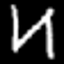

In [7]:
test_pic = Image.fromarray(image_list[-1]).convert('RGB')
print(label_names[label_list[-1] -1])
test_pic.resize((64, 64))

In [8]:
model = 'Resnet18'
root_dir = '/raceai/data/tmp/resnet18'
input_size = 28
mean = [
    0.1362,
    0.1362,
    0.1362
]
std = [
    0.2893,
    0.2893,
    0.2893
]
num_classes = 26
resume_weights = "/raceai/data/ckpts/letters/pl_resnet18_rotation.pth"

DATA_PROCESS_BASE64 = 'raceai.data.process.Base64DataLoader'

reqdata = '''{
    "task": "cls.inference.pl",
    "cfg": {
        "data": {
            "class_name": "%s",
            "params": {
                "data_source": %s,
                "dataset": {
                    "class_name": "raceai.data.PredictListImageDataset",
                     "params": {
                         "input_size": input_size,
                         "mean": mean,
                         "std": std
                     }
                 },
                "sample": {
                    "batch_size": 32,
                    "num_workers": 4,
                }
             }
        },
        "model": {
            "class_name": f"raceai.models.backbone.{model}",  
            "params": {
                "device": 'gpu',
                "num_classes": num_classes,
                "weights": False
            }
        },
        "trainer": {
            "default_root_dir": root_dir,
            "gpus": 1,
            "resume_from_checkpoint": resume_weights
        }
    }
}'''

In [9]:
images_labels = list(zip(image_list, label_list))
random.shuffle(images_labels)
for image, label in images_labels[:3]:
    b64str = img2b64(image)
    cfg = eval(reqdata % (DATA_PROCESS_BASE64, f"\"{b64str}\""))
    resdata = json.loads(requests.post(url=API_INFERENCE, json=cfg).text)
    if resdata['errno'] == 0:
        result = resdata['result'][0]
        probs = result['probs_sorted']['values'][0]
        index = result['probs_sorted']['indices'][0]
        print('{} vs {}({})'.format(label-1, index, probs))
    else:
        print(resdata)

7 vs 8(0.9523624777793884)
14 vs 14(0.9998741149902344)
5 vs 3(0.9909488558769226)


In [10]:
url_params = '?num_classes=26&ckpt_path=/raceai/data/ckpts/letters/pl_resnet18_rotation.pth'
IFrame(f'http://116.85.5.40:9091/handwritten.html{url_params}', width=300, height=300)

## 前端对接

步骤:

1. 选择模型(增强型,正常型)

2. 用户在画布上书写字母

3. (可选)旋转

4. 将最后的数字图片, 并进行base64编码

5. 调用接口`http://116.85.5.40:9119/raceai/framework/inference`

### 参数配置

#### 模型选择

- 旋转识别 (数据增强)

    ```
    cfg.model.params.num_classes = 26
    cfg.trainer.resume_from_checkpoint = /raceai/data/ckpts/letters/pl_resnet18_rotation.pth
    ```

- 正常识别

    ```
    cfg.trainer.resume_from_checkpoint = /raceai/data/ckpts/letters/pl_resnet18_normal.pth
    cfg.model.params.num_classes = 26
    ```


#### Base64数据

    cfg.data.data_source = "b64str"

#### 配置样例

In [11]:
b4str = img2b64(random.choice(image_list))
# b4str = img2b64('/data/image.png')
reqdata = '''{
    "task": "cls.inference.pl",
    "cfg": {
        "data": {
            "class_name": "raceai.data.process.Base64DataLoader",
            "params": {
                "data_source": "%s",
                "dataset": {
                    "class_name": "raceai.data.PredictListImageDataset",
                     "params": {
                         "input_size": 28,
                         "mean": [0.1362, 0.1362, 0.1362],
                         "std": [0.2893, 0.2893, 0.2893]
                     }
                 },
                "sample": {
                    "batch_size": 32,
                    "num_workers": 4,
                }
             }
        },
        "model": {
            "class_name": f"raceai.models.backbone.Resnet18",  
            "params": {
                "device": 'gpu',
                "num_classes": 26,
                "weights": False
            }
        },
        "trainer": {
            "default_root_dir": "/raceai/data/tmp/pl_resnet18",
            "gpus": 1,
            "resume_from_checkpoint": "/raceai/data/ckpts/letters/pl_resnet18_rotation.pth"
        }
    }
}''' % b4str


print(reqdata.replace('False', 'false').replace('True', 'true'))

{
    "task": "cls.inference.pl",
    "cfg": {
        "data": {
            "class_name": "raceai.data.process.Base64DataLoader",
            "params": {
                "data_source": "iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAByUlEQVRIS+3Vv6uBURgH8O/LZDAwmZUyKCmjVWLBZpSB/0DEYlAszCZl8lsWJYVJKUUiUkIMMigZKHJv7ym3Kzev972O5d4zvuftfM7znOc5hwHwgTcO5h/8KdtarZZ8lslkWCwWmM1mTx+KoJT2ej2sViuCbLdbuN1uHI/Hp1BB4GazQTgcRjKZRLFYhNPp/NoAlyoIrNfrsFqt2O/3CAQCqFQq6Ha7XBaZFwSWy2UCsoMFJ5MJcrnc+8BWq4VGo/E+MJ1OYzqd0gdLpRJUKhXMZjOWyyU9cLfbYT6fQ6lUwu/3I5FI4HQ60QOr1SpcLheJLBKJQKfT0Y3wWqVisRjBYBA+nw8SiYRehN/bglVGoxHG4zHsdjsnyrsPRSIR2GK59uFVaDabJMWHw+EhyhtUq9WIRqN34HA4RCgUQjabfS1YKBRIRTocjpuFLRYLpFIpMpnMa8H1eg2v14tUKnWzsNFohFwupwMqFIq7KGKxGNrtNh0wHo/fgR6PBzabDf1+/3UpNZlMYM+QvVnYajUYDDifz6jVahgMBpwFw/t50uv15FbJ5/NgGAYajQaXywWdTofui8/Z3Q9+4N2Hv8F4p/S32N8APwFqxN8BKXJdkQAAAABJRU5ErkJggg==",
                "dataset": {
                    "class_name": "raceai.data.PredictListImageDataset",
                    

### 接口请求/响应

![](/files/assets/images/emnist_letters.png)

In [12]:
resdata = json.loads(requests.post(url=API_INFERENCE, json=eval(reqdata)).text)
resdata 

{'errno': 0,
 'result': [{'image_id': '-1',
   'image_path': '/tmp/b4img_1609914084.png',
   'probs': [3.369447654222313e-07,
    0.9995549321174622,
    8.612280453235144e-07,
    5.9320864238543436e-05,
    1.1153422292409232e-06,
    4.3539944272197317e-07,
    0.0001561387616675347,
    2.597820639493875e-06,
    8.710812693379921e-08,
    3.320046459975856e-08,
    3.8902084043002105e-07,
    0.0001731865486362949,
    4.467546610431583e-10,
    1.5228943661682592e-09,
    2.6077306756633334e-05,
    1.5854728189879097e-05,
    2.860735776266665e-06,
    8.101888937517288e-08,
    3.1698057227913523e-06,
    1.245343383970976e-07,
    1.3112262422509957e-06,
    1.7948480035556713e-07,
    4.832198783333297e-07,
    1.1702612567887627e-07,
    2.2802138843758257e-08,
    2.978565021294344e-07],
   'probs_sorted': {'indices': [1,
     11,
     6,
     3,
     14,
     15,
     18,
     16,
     7,
     20,
     4,
     2,
     22,
     5,
     10,
     0,
     25,
     21,
     19,